# Recurrent Neural Networks

### Practical Session

<br/> Prof. Dr. Georgios K. Ouzounis
<br/> email: georgios.ouzounis@go.kauko.lt

## Contents

1. Data loading and pre-processing
2. Building the RNN
3. Train and deploy the RNN
4. Improving the RNN

## Challenge

In [1]:
#Check the past 10 years stocks of chosen company in my case it was AMD

In [2]:
# importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Import the dataset

In [3]:
#Dataset description: the open high, low and close values of the AMD from 2009 to 2019

In [4]:
#importing the the training dataset

# load the file contents 
dataset_train = pd.read_csv('AMD_train.csv')

In [5]:
#checking if we got correct information from AMD_train.csv
dataset_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,7/31/2009,3.66,3.73,3.65,3.66,3.66,14282400
1,8/3/2009,3.75,3.78,3.70,3.74,3.74,12875200
2,8/4/2009,3.75,3.85,3.68,3.76,3.76,20095900
3,8/5/2009,3.77,3.79,3.70,3.75,3.75,12174500
4,8/6/2009,3.75,3.79,3.66,3.71,3.71,11660200


In [6]:
#  create a subtable of relevant entries (open values)
# The .values makes this vector a numpy array
training_set = dataset_train.iloc[:, 1:2].values 

In [7]:
training_set

array([[ 3.66    ],
       [ 3.75    ],
       [ 3.75    ],
       ...,
       [34.23    ],
       [34.139999],
       [33.209999]])

Numpy arrays do not support the view() and head() methods. [More on accessing the numpy data](https://jakevdp.github.io/PythonDataScienceHandbook/02.02-the-basics-of-numpy-arrays.html)


### Feature Scaling

Next we need to rescale our data to the range from 0 to 1. 

Feature scaling is essential as discussed if the Features lecture and needs to be applied to both the training and test sets.

It is computed using the ScikitLearn library [MinMaxScaler()](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler) which transforms the selected feature by scaling it to a given range. If more than one, this estimator scales and translates each feature individually such that it is in the given range on the training set, i.e. between zero and one.

In [8]:
# Feature Scaling

# import the MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

In [9]:
# create a scaler instance to rescale all data to the range of 0.0 to 1.0 
sc = MinMaxScaler(feature_range = (0, 1))

In [10]:
# create the actual training set of scaled values
training_set_scaled = sc.fit_transform(training_set)

In [11]:
training_set_scaled

array([[0.0624235 ],
       [0.06517748],
       [0.06517748],
       ...,
       [0.99785805],
       [0.99510404],
       [0.96664627]])

### Splitting the training set to dependent and independent variables

<img src="https://drive.google.com/uc?id=1bckuLGZCeLUzNA-xJCGOODzC-4n2U-If"/>

In [13]:
# Creating a data structure with 90 timesteps and 1 output

# the 90 stock prices in the last 3 months before today
X_train = [] 

In [14]:
#I think that we check for maximum range for 
training_set_scaled.shape

(2516, 1)

In [15]:
# the stock price today
y_train = [] 

In [16]:
# we start from day 90 because that is the first instance allowing us to 
# go back 90 days
for i in range(90, 2516): 
    # 0 is the column ID, the only column in this case.
    # put the last 90 days values in one row of X_train
    X_train.append(training_set_scaled[i-90:i, 0]) 
    y_train.append(training_set_scaled[i, 0])


In [17]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [18]:
X_train

array([[0.0624235 , 0.06517748, 0.06517748, ..., 0.1759486 , 0.19798042,
        0.20287638],
       [0.06517748, 0.06517748, 0.06578948, ..., 0.19798042, 0.20287638,
        0.20838434],
       [0.06517748, 0.06578948, 0.06517748, ..., 0.20287638, 0.20838434,
        0.22001225],
       ...,
       [0.67258264, 0.76101594, 0.73929014, ..., 0.96542224, 0.97980416,
        0.99235006],
       [0.76101594, 0.73929014, 0.79314571, ..., 0.97980416, 0.99235006,
        0.99785805],
       [0.73929014, 0.79314571, 0.75489601, ..., 0.99235006, 0.99785805,
        0.99510404]])

If we were to add the stock value of somebody else together with the the past 60 days of Google, we need to change the length of the 3 dimension to  2.  RNN training tables are 3D!!! Read: [Reshaping NumPy Array | Numpy Array Reshape Examples](https://backtobazics.com/python/python-reshaping-numpy-array-examples/)

In [19]:
# Reshaping the data matrix, we retain the 2 original dimensions and add a third of depth=1
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Building the RNN

### RNN initialization

- Import the sequential model from the Keras API;
- Import the Dense layer template from the Keras API;
- Import the LSTM model from the Keras API
- Create an instance of the sequential model called regressor because we want to predict a continuous value

In [20]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [21]:
# Initialising the RNN as a sequence of layers
regressor = Sequential()

### Add First Layer

We first add an object of the LSTM class! 

- The first argument is the number of units or LSTM memory cells. Include many neurons to address the high dimensionality of the problem; say 50 neurons! 
- Second arg: return sequences = true; stacked LSTM !
- Third arg: input 3D shape: observations vs time steps vs number of indicators

In [22]:
# Adding the input layer and the LSTM layer
regressor.add(LSTM(units = 50, return_sequences = True, input_shape =  (X_train.shape[1], 1)))

In [23]:
# the argument is the dropout rate to ignore in the layers (20%), 
# i.e. 50 units * 20% = 10 units will be dropped each time
regressor.add(Dropout(0.2))


### Add More Layers

We can add more LSTM layers but along with Dropout regularization to make sure we avoid overfitting! 

We don’t need to add the shape of the layer again because it is recognized automatically from the number of input units.

The last layer does not return a sequence but connected directly to a fully connected output layer.


In [24]:
# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [25]:
# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [26]:
# Adding a fourth LSTM layer and some Dropout regularisation
# we removed the return_sequences because we no longer return a 
# sequence but a value instead
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

### Add Output Layer & Compile

The output has 1 dimension , i.e. one value to be predicted thus or output fully connected layer has dimensionality = 1.

- **Optimizer**: rmsprop is recommended in the Keras documentation. The Adam optimizer is also a powerful choice.
- **Loss function**: regression problems take the mean square error as most common

In [27]:
# Adding the output layer
regressor.add(Dense(units = 1))

In [28]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

## Train and deploy the RNN

### Fit the RNN to the Training set

We now want to train our RNN using the data in our **Training Set X** and **predictors in y** (ground truth in this case). Parameters that can be specified are the:

- **Batch size**:  update the cell weights not on every stock price on every batch_size values; 
- **Number of epochs**: how many iterations to be used, i.e. number of forward and backward propagations for the update of the weights


In [29]:
# Letting the program about sets of training and predictions
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
76/76 [==============================] - 17s 227ms/step - loss: 0.0070
Epoch 2/100
76/76 [==============================] - 16s 212ms/step - loss: 0.0030
Epoch 3/100
76/76 [==============================] - 12s 152ms/step - loss: 0.0024
Epoch 4/100
76/76 [==============================] - 10s 133ms/step - loss: 0.0025
Epoch 5/100
76/76 [==============================] - 10s 137ms/step - loss: 0.0022
Epoch 6/100
76/76 [==============================] - 10s 134ms/step - loss: 0.0017
Epoch 7/100
76/76 [==============================] - 11s 139ms/step - loss: 0.0017
Epoch 8/100
76/76 [==============================] - 11s 139ms/step - loss: 0.0015
Epoch 9/100
76/76 [==============================] - 10s 134ms/step - loss: 0.0015
Epoch 10/100
76/76 [==============================] - 10s 133ms/step - loss: 0.0014
Epoch 11/100
76/76 [==============================] - 10s 133ms/step - loss: 0.0016
Epoch 12/100
76/76 [==============================] - 10s 134ms/step - loss: 0.0020
E

### Computing Predictions

Create a data-frame by importing the Google Stock Price Test set for January 2017 using pandas and make it a numpy array.

There are 20 financial days in one month, weekends are excluded!


In [30]:
# Getting the real stock price for August1st 20019 - 
# August 31st 2019

dataset_test = pd.read_csv('AMD_Test.csv')
dataset_test

,Date,Open,High,Low,Close,Adj Close,Volume
0,8/1/2019,30.500000,31.480000,29.100000,29.860001,29.860001,80878900
1,8/2/2019,29.480000,29.730000,28.940001,29.440001,29.440001,60410900
2,8/5/2019,28.260000,28.490000,27.650000,27.990000,27.990000,74333200
3,8/6/2019,28.860001,29.049999,28.200001,28.860001,28.860001,60578400
4,8/7/2019,28.469999,29.280001,28.370001,29.190001,29.190001,58577500
5,8/8/2019,31.530001,34.270000,31.480000,33.919998,33.919998,167278800
6,8/9/2019,33.450001,35.549999,33.080002,34.189999,34.189999,132483900
7,8/12/2019,34.160000,34.650002,32.080002,32.430000,32.430000,106737000
8,8/13/2019,32.360001,33.139999,31.719999,32.110001,32.110001,102009700
9,8/14/2019,31.000000,31.049999,29.510000,30.240000,30.240000,127521500


In [31]:
#checking for how many real stocks there are
real_stock_price = dataset_test.iloc[:, 1:2].values
real_stock_price.size

22

In [32]:
#checking for opening numbers
real_stock_price

array([[30.5     ],
       [29.48    ],
       [28.26    ],
       [28.860001],
       [28.469999],
       [31.530001],
       [33.450001],
       [34.16    ],
       [32.360001],
       [31.      ],
       [30.629999],
       [30.309999],
       [32.      ],
       [30.940001],
       [31.049999],
       [31.76    ],
       [31.299999],
       [30.34    ],
       [30.6     ],
       [29.92    ],
       [31.469999],
       [31.6     ]])

To predict the stock price value for each day in January 2017, we need the values in the last 60 days.

To obtain this **history** we need to combine both the training and test sets in one.

If we were to use the training_set and test_set we would need to use the scaler  but that would change the actual test values.  Thus concatenate the original data frames!


In [33]:
# Getting the predicted stock price of 2019

# axis = 0 means concatenate the lines (i.e. vertical axis)
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0) 

In [34]:
#Checking for how many entries there are.
dataset_total.size


2538

In [35]:
# the difference in the length of the first two gives us 
# the first day in 2019, and we need to go back 90 days to get the necessary range
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 90:].values

In [36]:

inputs.size

112

In [37]:
# we did not use iloc from panda so lets reshape the numpy array for 
# compatibility: i.e. all the values from input lines to be stacked in one 
# column. The -1 means that the numpy has no knowledge of how the 
# values were stored in lines. The 1 means we want to them in one 
# column.

inputs = inputs.reshape(-1,1) 

# apply the feature scaler
inputs = sc.transform(inputs)

In [38]:
# Getting the predicted stock price of 2019
X_test = []

In [39]:
# the first 90 from inputs are from training set; start 
# from 90 and get the extra 22, i.e. up to 112
for i in range(90, 112): 
    X_test.append(inputs[i-90:i, 0])


In [40]:
X_test = np.array(X_test) # 

In [41]:
# create a 3D structure
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [42]:
predicted_stock_price = regressor.predict(X_test)

In [43]:
# need to inverse the scaling to get meaningful predicted stock price # outputs
predicted_stock_price = sc.inverse_transform(predicted_stock_price) 
predicted_stock_price.size

22

### Result Visualization


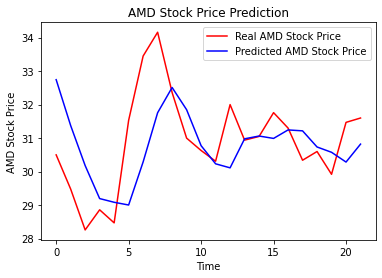

In [44]:
# Visualising the results

plt.plot(real_stock_price, color = 'red', label = 'Real AMD Stock Price')

plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted AMD Stock Price')

plt.title('AMD Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AMD Stock Price')
plt.legend()

plt.show()

In [45]:
#import the libraries
import math
from sklearn.metrics import mean_squared_error

In [46]:
#what is the difference(the perfect outcome is getting 0)
#
rmse = math.sqrt( mean_squared_error( real_stock_price[0:22,:], predicted_stock_price))
rmse

1.3998140191908426

## Improving the RNN

The new data need to be placed in the same order/format  as in the case of the training/test sets.

1. Getting more training data: we trained our model on the past 5 years of the  Google Stock Price but it would be even better to train it on the past 10 years.

2. Increasing the number of time steps: the model remembered the stock price from the 60 previous financial days to predict the stock price of the next day. That’s because we chose a number of 60 time steps (3 months). You could try to increase the number of time steps, by choosing for example 120 time steps (6 months).

3. Adding some other indicators: if you have the financial instinct that the stock price of some other companies might be correlated to the one of Google, you could add this other stock price as a new indicator in the training data.

4. Adding more LSTM layers: we built a RNN with four LSTM layers but you could try with even more.

5. Adding more neurons in the LSTM layers: we highlighted the fact that we needed a high number of neurons in the LSTM layers to respond better to the complexity of the problem and we chose to include 50 neurons in each of our 4 LSTM layers. You could try an architecture with even more neurons in each of the 4 (or more) LSTM layers.

### Fine tuning the RNN

Parameter Tuning on the RNN model: we are dealing with a Regression problem because we predict a continuous outcome.

**Tip**: replace: scoring = 'accuracy' by scoring = 'neg_mean_squared_error' in the GridSearchCV class parameters as we did in the ANN case.